In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling2D , GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_256_aug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256_aug.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 13.9 s, sys: 22 s, total: 35.9 s
Wall time: 3min 41s


In [4]:
train_df.reset_index(inplace=True)
valid_df.reset_index(inplace=True)
unknown_df.reset_index(inplace=True)
silent_df.reset_index(inplace=True)

In [5]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*2)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [6]:
%time t = next(train_generator(256))[0][0].T

CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 133 ms


In [6]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [24]:
def test_pseudo_generator(test_batch_size):
#     this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
#     this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [25]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [26]:
mi = MixIterator([train_generator(50), test_pseudo_generator(14)])


In [31]:
valid_df.label_id.value_counts()

11    4221
1      270
3      264
0      261
2      260
9      260
10     257
6      257
7      256
5      256
4      247
8      246
Name: label_id, dtype: int64

In [67]:
%time t = next(valid_generator(64))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.89 ms


In [68]:
valid_df.loc[0,'raw'].shape

(256, 32)

In [69]:
t[0].shape

(64, 32, 256)

In [7]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [8]:
p = 0.3


### Model

In [7]:
def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [8]:
from keras.layers import ConvLSTM2D, Bidirectional, CuDNNLSTM, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [6]:
p = 0.

def get_conv_stacks( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    x =  Reshape((timesteps, input_dim,1))(x_in)
    
    
    
    x = Conv2D(32,(7,7),padding='same')(x)
    x = batch_relu(x)

    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)

    
    x = MaxPooling2D((1,3))(x)
    
    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)

    
    
    x = MaxPooling2D((2,3))(x)
    

    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)

    x = MaxPooling2D((1,3))(x)
    
    
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
#     print x.shape
    x = Reshape((16,9*128))(x)
    
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)
    x = Drop



    
    return x

In [9]:

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [139]:


def ResNet50(img_input):
    

    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(
        64, (7, 7), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((1, 3))(x)

    x = conv_block(x, 3, [32, 32, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='b')
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='c')
    
    
    x = MaxPooling2D((1, 3))(x)

    
    

    x = conv_block(x, 3, [64, 64, 128], stage=3, block='a')
    x = identity_block(x, 3, [64, 64, 128], stage=3, block='b')
    x = identity_block(x, 3, [64, 64, 128], stage=3, block='c')
    x = identity_block(x, 3, [64, 64, 128], stage=3, block='d')

#     x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

#     x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((1, 2), name='avg_pool')(x)

#     x = GlobalMaxPooling2D()(x)
    x = Reshape((16,int(x.shape[-1]) * int(x.shape[-2])))(x)  #x = Reshape((16,9*128))(x)
    
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)
    # Create model.
    return x

In [140]:
# p = 0.3

timesteps, input_dim , latent_dim = 32,256, 128

x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]
x = BatchNormalization()(x_logml)
x = Reshape((timesteps, input_dim, 1))(x)
# x = get_conv_stacks(x_logml)
x = ResNet50(x)


x = Dense(128, activation = 'relu')(x) #
x = Dropout(0.3)(x)



x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [141]:

model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [142]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 32, 256)      0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 256)      1024        input_32[0][0]                   
__________________________________________________________________________________________________
reshape_63 (Reshape)            (None, 32, 256, 1)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 256, 64)  3200        reshape_63[0][0]                 
__________________________________________________________________________________________________
bn_conv1 (

In [143]:
from keras.callbacks import TensorBoard
exp_name = "conv2d_resnet_lstm" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [144]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 199s 603ms/step - loss: 1.6549 - acc: 0.4150 - val_loss: 0.8575 - val_acc: 0.7131
Epoch 2/100
110/329 [=========>....................] - ETA: 1:25 - loss: 0.8721 - acc: 0.7081

KeyboardInterrupt: 

In [15]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [13]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

NameError: name 'valid_generator' is not defined

In [67]:
val_preds.shape

(7055,)

In [68]:
oe = OneHotEncoder()

In [69]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [70]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [71]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.91      0.95      0.93       270
         up       0.93      0.94      0.94       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.95      0.97      0.96       256
         on       0.95      0.95      0.95       257
        off       0.92      0.96      0.94       256
       stop       0.95      0.96      0.95       246
         go       0.92      0.92      0.92       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [113]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.94      0.93       270
         up       0.89      0.93      0.91       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.96      0.97      0.97       256
         on       0.91      0.95      0.93       257
        off       0.92      0.95      0.93       256
       stop       0.97      0.95      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [63]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.91      0.94      0.92       270
         up       0.93      0.92      0.92       260
       down       0.93      0.97      0.95       264
       left       0.95      0.98      0.96       247
      right       0.95      0.95      0.95       256
         on       0.93      0.93      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.96      0.94      0.95       246
         go       0.90      0.91      0.90       260
    silence       0.99      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [32]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.97      0.95      0.96       264
       left       0.97      0.98      0.97       247
      right       0.97      0.94      0.96       256
         on       0.95      0.94      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.97      0.91      0.94       246
         go       0.88      0.87      0.87       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [176]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.93      0.92       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.96       264
       left       0.95      0.98      0.97       247
      right       0.97      0.95      0.96       256
         on       0.94      0.94      0.94       257
        off       0.90      0.95      0.92       256
       stop       0.96      0.94      0.95       246
         go       0.92      0.92      0.92       260
    silence       1.00      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [107]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.89      0.92      0.90       270
         up       0.92      0.94      0.93       260
       down       0.96      0.97      0.96       264
       left       0.96      0.98      0.97       247
      right       0.97      0.97      0.97       256
         on       0.93      0.95      0.94       257
        off       0.92      0.97      0.94       256
       stop       0.97      0.94      0.96       246
         go       0.91      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [78]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.88      0.91      0.89       270
         up       0.86      0.95      0.90       260
       down       0.92      0.95      0.93       264
       left       0.94      0.98      0.96       247
      right       0.94      0.95      0.95       256
         on       0.83      0.94      0.88       257
        off       0.87      0.94      0.90       256
       stop       0.98      0.93      0.95       246
         go       0.80      0.90      0.85       260
    silence       0.95      1.00      0.98       257
    unknown       0.98      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.92      0.92       270
         up       0.93      0.93      0.93       260
       down       0.99      0.95      0.97       264
       left       0.98      0.97      0.97       247
      right       0.99      0.95      0.97       256
         on       0.97      0.92      0.95       257
        off       0.94      0.92      0.93       256
       stop       0.99      0.94      0.97       246
         go       0.95      0.88      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.76      0.98      0.86       257

avg / total       0.95      0.94      0.94      3091



In [95]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.92      0.94      0.93       270
         up       0.92      0.93      0.93       260
       down       0.98      0.94      0.96       264
       left       0.97      0.97      0.97       247
      right       0.95      0.96      0.96       256
         on       0.96      0.95      0.96       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.94      0.97       246
         go       0.96      0.89      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.95      0.88       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



In [197]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.91      0.94      0.93       270
         up       0.90      0.95      0.92       260
       down       0.99      0.94      0.96       264
       left       0.98      0.98      0.98       247
      right       0.98      0.96      0.97       256
         on       0.98      0.93      0.95       257
        off       0.93      0.93      0.93       256
       stop       0.96      0.93      0.95       246
         go       0.95      0.90      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.94      0.87       257

avg / total       0.95      0.95      0.95      3091



### submission


In [17]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [18]:
len(test_paths)

158538

In [19]:
test_df = pickle.load( open("cache/test_df_256.pik","rb"))


In [20]:
test_df.shape

(158538, 5)

In [112]:
test_df.head()

,label,label_id,user_id,wav_file,raw
0,test,-1,test,./data/test/audio/clip_bd6d0fb25.wav,"[[-57.2323073539, -62.8251292953, -75.84322783..."
1,test,-1,test,./data/test/audio/clip_3e7a56353.wav,"[[-58.4158758303, -52.5011356178, -53.86649120..."
2,test,-1,test,./data/test/audio/clip_c5884a6cb.wav,"[[-73.8001558488, -76.330194253, -72.386112091..."
3,test,-1,test,./data/test/audio/clip_ebf0d1f7b.wav,"[[-71.7484306025, -64.9348066752, -62.39292603..."
4,test,-1,test,./data/test/audio/clip_2f714f052.wav,"[[-49.6434011746, -49.9060486303, -49.58891626..."


In [23]:
batch_size = 64 

def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [24]:
predictions = model.predict_generator(test_generator(batch_size), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 224s 90ms/step


In [25]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [26]:
predictions.shape

(158538, 12)

#### blending

In [35]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
# blend1 = np.load('cache/predictions_blend_dilated_conv1d_timek123_n_freqk48_pseudo_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")
blend2 = np.load('cache/predictions_frqmaxpool256_plus_longblend1.npy')

In [37]:
blend3 = np.mean([predictions,
                       blend2], axis=0)


In [38]:
np.save("cache/predictions_{}.npy".format("conv2dlstm_plus_longblend1"),blend3)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [39]:
classes = np.argmax(blend3, axis=1)

In [40]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 12199.,   5935.,   5504.,   6475.,   5714.,   6248.,   6733.,
          5834.,   5656.,  98240.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

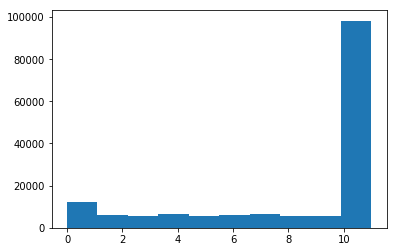

In [41]:
plt.hist(classes,bins=10)

(array([ 12386.,   5903.,   5706.,   6784.,   6044.,   6438.,   7151.,
          6109.,   5953.,  96064.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

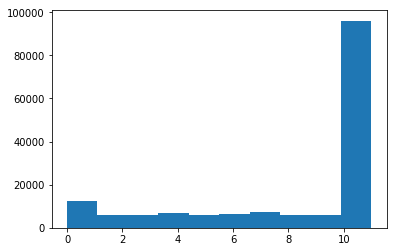

In [30]:
plt.hist(classes,bins=10)

(array([ 12582.,   6037.,   5315.,   6311.,   5686.,   6582.,   6293.,
          5509.,   5620.,  98603.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

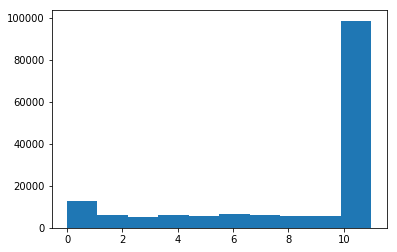

In [128]:
plt.hist(classes,bins=10)

(array([ 12814.,   5817.,   5536.,   6438.,   6017.,   6818.,   6597.,
          5552.,   5591.,  97358.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

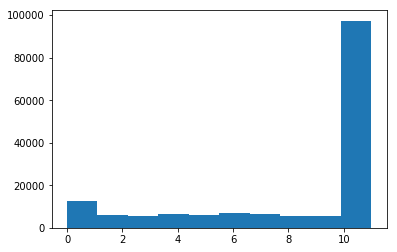

In [119]:
plt.hist(classes,bins=10)

(array([ 12794.,   6163.,   4986.,   6304.,   5482.,   6953.,   6442.,
          5801.,   5803.,  97810.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

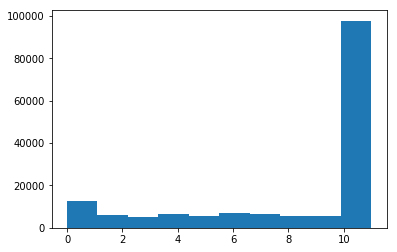

In [38]:
plt.hist(classes,bins=10)

(array([ 13314.,   6425.,   5008.,   5968.,   5353.,   7153.,   6788.,
          5934.,   6366.,  96229.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

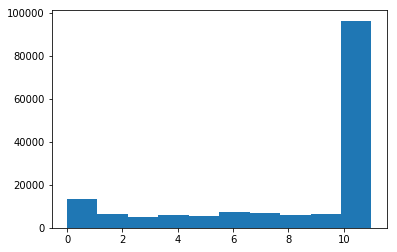

In [28]:
plt.hist(classes,bins=10)

(array([ 12750.,   6091.,   5142.,   6350.,   5542.,   6960.,   6424.,
          5745.,   6265.,  97269.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

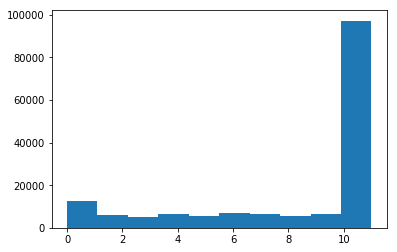

In [224]:
plt.hist(classes,bins=10)

(array([ 13344.,   6234.,   5208.,   6607.,   5785.,   7365.,   6680.,
          5825.,   6508.,  94982.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

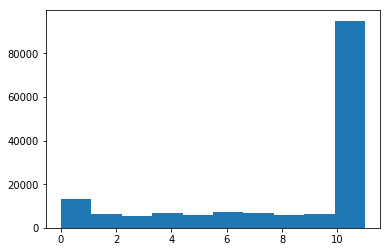

In [212]:
plt.hist(classes,bins=10)

### submission

In [42]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [43]:
with open('subm/{}_88_plus_longblend1_87.csv'.format(exp_name), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [44]:
from IPython.lib.display import FileLink

FileLink('subm/{}_88_plus_longblend1_87.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/conv2d_wlstm_88_plus_longblend1_87.csv